# Elo Score Calculation

In [1]:
import re
import os
import sys
from collections import defaultdict
import glob
import warnings

In [2]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import xlrd

In [4]:
# setting path
sys.path.append('../../src')

In [5]:
from eloscore import eloscore

In [6]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

## Summary

- Notebook that calcuates the Elo Score of mice competing over access to a tone associated reward port
- The data is a spreadsheet of combination of subjects (as rows) against dates (as columns)

## Getting the file name

- Searching for files that are in the `./data` folder (in the folder that this notebook is in) that have `home` in the file name

In [7]:
input_folder = "./data"

In [8]:
raw_data_file_keyword = '*[tT]ube*'

In [9]:
# Searching for matching files with recursion
if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
    raw_data_files_list = glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword))
# Searching for matching files only in the folder
elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
    raw_data_files_list = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
else:
    raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))

In [10]:
raw_data_files_list

['./data/Tube_test_data_pilot_of_pilot.xlsx']

In [11]:
raw_data_file_path = raw_data_files_list[0]

In [12]:
raw_data_file_path

'./data/Tube_test_data_pilot_of_pilot.xlsx'

## Importing Data for One Sheet

- The original data has been trimmed so that only the cells with dates, winner ID's, and relevant metadata were kept

In [13]:
xls = pd.ExcelFile(raw_data_file_path)
sheets = xls.sheet_names

In [14]:
sheets

['CAGE1', 'CAGE 2', 'CAGE 3', 'CAGE 4', 'cage 1-4']

In [15]:
# Seeing if "Unnamed" is in any of the cells for the 0th row
if "Unnamed" not in "".join([str(col) for col in pd.read_excel(raw_data_file_path, sheet_name=sheets[0], header=0).columns]):
    header_row = 0
# Seeing if "Unnamed" is in any of the cells for the 1st row
elif "Unnamed" not in "".join([str(col) for col in pd.read_excel(raw_data_file_path, sheet_name=sheets[0], header=1).columns]):
    header_row = 1
else:
    header_row = 0
    warnings.warn("""Both the 0th and the 1st row have cells with blank values. This means that that these rows can not be used as headers. Please change the row number to the header""")


In [16]:
tube_test_observations_df = pd.read_excel(raw_data_file_path, sheet_name=sheets[0], header=header_row)

In [17]:
tube_test_observations_df.head()

,Runner,Date,Match,Winner,Loser,Notes
0,JS,2022-04-25,1.1 v 2.2,1.1,2.2,NaN
1,NaN,NaT,2.2 v 2.3,2.2,2.3,NaN
2,NaN,NaT,2.3 v 1.4,1.4,2.3,NaN
3,NaN,NaT,1.4 v 1.1,1.4,1.1,NaN
4,NaN,NaT,2.2 v 1.4,1.4,2.2,NaN


## Standarizing the Column

In [18]:
original_column_name_to_standarized = defaultdict(dict)
for col in tube_test_observations_df.columns:
    original_column_name_to_standarized[col] = str(col).lower().strip()

In [19]:
original_column_name_to_standarized

defaultdict(dict,
            {'Runner': 'runner',
             'Date': 'date',
             'Match': 'match',
             'Winner': 'winner',
             'Loser ': 'loser',
             'Notes': 'notes'})

In [20]:
tube_test_observations_df = tube_test_observations_df.rename(columns=original_column_name_to_standarized)

In [21]:
tube_test_observations_df.head()

,runner,date,match,winner,loser,notes
0,JS,2022-04-25,1.1 v 2.2,1.1,2.2,NaN
1,NaN,NaT,2.2 v 2.3,2.2,2.3,NaN
2,NaN,NaT,2.3 v 1.4,1.4,2.3,NaN
3,NaN,NaT,1.4 v 1.1,1.4,1.1,NaN
4,NaN,NaT,2.2 v 1.4,1.4,2.2,NaN


## Adding the session number

- Each new session has the date as a row, so we will get the index of all the rows with dates

In [22]:
tube_test_observations_df.dropna(axis=0, subset="date")

,runner,date,match,winner,loser,notes
0,JS,2022-04-25,1.1 v 2.2,1.1,2.2,NaN
6,JS/MC,2022-04-26,1.1 v 2.2,1.1,2.2,NaN
12,JS/MC/NL,2022-04-27,1.1 v 2.2,1.1,2.2,NaN
18,JS/NL/ERW,2022-04-28,1.1 v 2.2,2.2,1.1,NaN
24,JS/NL,2022-04-29,1.1 v 2.2,1.1,2.2,NaN
30,NL,2022-05-02,1.1 v 2.2,1.1,2.2,NaN
36,NL,2022-05-05,1.1 v 2.2,1.1,2.2,NaN
42,NL,2022-05-06,1.1 v 2.2,1.1,2.2,NaN
48,NL,2022-05-09,1.1 v 2.2,1.1,2.2,NaN
54,NL/EZ/EW,2022-05-10,1.1 v 2.2,1.1,2.2,NaN


- Getting the indexes of where each new session starts

In [23]:
tube_test_observations_df.dropna(axis=0, subset="date").index

Int64Index([0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78], dtype='int64')

In [24]:
session_indexes = tube_test_observations_df.dropna(axis=0, subset="date").index

- Adding a column for the session number and then filling all the `NaNs`

In [25]:
tube_test_observations_df = eloscore.add_session_number_column(tube_test_observations_df, session_indexes)
tube_test_observations_df = tube_test_observations_df.fillna(method='ffill')

- Making another column for plotting

In [26]:
tube_test_observations_df = eloscore.add_session_number_column(tube_test_observations_df, session_indexes, session_number_column="session_number_plotting")

In [27]:
tube_test_observations_df.head()

,runner,date,match,winner,loser,notes,session_number,session_number_plotting
0,JS,2022-04-25,1.1 v 2.2,1.1,2.2,NaN,1.0,1.0
1,JS,2022-04-25,2.2 v 2.3,2.2,2.3,NaN,1.0,NaN
2,JS,2022-04-25,2.3 v 1.4,1.4,2.3,NaN,1.0,NaN
3,JS,2022-04-25,1.4 v 1.1,1.4,1.1,NaN,1.0,NaN
4,JS,2022-04-25,2.2 v 1.4,1.4,2.2,NaN,1.0,NaN


## Calculating ELO Score

- Example calculation

In [28]:
eloscore.calculate_elo_score(subject_elo_score=1000, agent_elo_score=2000)

1020

## Get the Elo score for all the events

In [29]:
tube_test_observations_df.head()

,runner,date,match,winner,loser,notes,session_number,session_number_plotting
0,JS,2022-04-25,1.1 v 2.2,1.1,2.2,NaN,1.0,1.0
1,JS,2022-04-25,2.2 v 2.3,2.2,2.3,NaN,1.0,NaN
2,JS,2022-04-25,2.3 v 1.4,1.4,2.3,NaN,1.0,NaN
3,JS,2022-04-25,1.4 v 1.1,1.4,1.1,NaN,1.0,NaN
4,JS,2022-04-25,2.2 v 1.4,1.4,2.2,NaN,1.0,NaN


In [30]:
eloscore.update_elo_score(winner_id="A", loser_id="B")

defaultdict(<function eloscore.eloscore.update_elo_score.<locals>.<lambda>()>,
            {'A': 1010.0, 'B': 990.0})

- Function that creates a dictionary that has the original/updated elo score for each event

In [31]:
index_to_elo_score_and_meta_data = eloscore.iterate_elo_score_calculation_for_data_frame(data_frame=tube_test_observations_df, winner_column="winner", loser_column="loser", additional_columns=["date", "session_number", "session_number_plotting"])

In [32]:
index_to_elo_score_and_meta_data[0]

{'total_match_number': 1,
 'subject_id': 1.1,
 'agent_id': 2.2,
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1,
 'date': Timestamp('2022-04-25 00:00:00'),
 'session_number': 1.0,
 'session_number_plotting': 1.0}

- Turning the dictionary into a dataframe

In [33]:
tube_test_elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

In [34]:
tube_test_elo_score_df.head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number,session_number_plotting
0,1,1.1,2.2,1000.0,1010.0,1,2022-04-25,1.0,1.0
1,1,2.2,2.2,1000.0,990.0,1,2022-04-25,1.0,1.0
2,2,2.2,2.3,990.0,1000.3,1,2022-04-25,1.0,NaN
3,2,2.3,2.3,1000.0,989.7,1,2022-04-25,1.0,NaN
4,3,1.4,2.3,1000.0,1009.7,1,2022-04-25,1.0,NaN


In [35]:
tube_test_elo_score_df.tail()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number,session_number_plotting
163,82,1.1,1.1,1064.6,1058.9,1,2022-05-20,14.0,NaN
164,83,1.4,2.2,1232.0,1235.0,1,2022-05-20,14.0,NaN
165,83,2.2,2.2,930.1,927.1,1,2022-05-20,14.0,NaN
166,84,1.1,2.3,1058.9,1062.2,1,2022-05-20,14.0,NaN
167,84,2.3,2.3,779.0,775.7,1,2022-05-20,14.0,NaN


In [36]:
tube_test_elo_score_df.groupby("subject_id").count()

,total_match_number,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number,session_number_plotting
subject_id,,,,,,,,
1.1,42,42,42,42,42,42,42,14
1.4,42,42,42,42,42,42,42,0
2.2,42,42,42,42,42,42,42,14
2.3,42,42,42,42,42,42,42,0


In [37]:
tube_test_elo_score_df.groupby("session_number").count()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number_plotting
session_number,,,,,,,,
1.0,12,12,12,12,12,12,12,2
2.0,12,12,12,12,12,12,12,2
3.0,12,12,12,12,12,12,12,2
4.0,12,12,12,12,12,12,12,2
5.0,12,12,12,12,12,12,12,2
6.0,12,12,12,12,12,12,12,2
7.0,12,12,12,12,12,12,12,2
8.0,12,12,12,12,12,12,12,2
9.0,12,12,12,12,12,12,12,2


# Plotting the Elo Score by match number

In [38]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

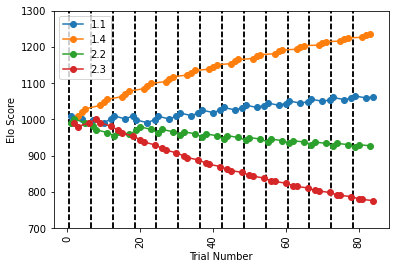

In [39]:
fig, ax = plt.subplots()

# Drawing vertical lines that represent when each session begins
for index, row in tube_test_elo_score_df.dropna(subset=["session_number_plotting"]).iterrows():
    # Offsetting by 0.5 to avoid drawing the line on the dot
    plt.vlines(x=[row["total_match_number"] - 0.5], ymin=700, ymax=1300, colors='black', linestyle='dashed')

# Drawing a line for each subject
for subject in sorted(tube_test_elo_score_df["subject_id"].unique()):
    # Getting all the rows with the current subject
    subject_df = tube_test_elo_score_df[tube_test_elo_score_df["subject_id"] == subject]
    # Making the dates into days after the first session by subtracting all the dates by the first date
    plt.plot(subject_df["total_match_number"], subject_df["updated_elo_score"], '-o', label=subject)

# Labeling the X/Y Axis and the title
ax.set_xlabel("Trial Number")
ax.set_ylabel("Elo Score")
# ax.set_title("Elo Score for Home Cage Observation: Cage {}".format(cage))
# To show the legend
ax.legend()
plt.xticks(rotation=90)
plt.ylim(700, 1300) 
plt.show()



# Calculate the Elo Score for all sheets

In [40]:
xls = pd.ExcelFile(raw_data_file_path)
sheets = xls.sheet_names

In [41]:
sheets

['CAGE1', 'CAGE 2', 'CAGE 3', 'CAGE 4', 'cage 1-4']

In [69]:
sheet_to_data_frame = defaultdict(dict)
for sheet in sheets[:]:
    try:
        print(sheet)
        # Seeing if "Unnamed" is in any of the cells for the 0th row
        if "Unnamed" not in "".join([str(col) for col in pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0).columns]):
            header_row = 0
        # Seeing if "Unnamed" is in any of the cells for the 1st row
        elif "Unnamed" not in "".join([str(col) for col in pd.read_excel(raw_data_file_path, sheet_name=sheet, header=1).columns]):
            header_row = 1
        else:
            header_row = 0
            warnings.warn("""Both the 0th and the 1st row have cells with blank values. This means that that these rows can not be used as headers. Please change the row number to the header""")
            continue
        
        sheet_to_data_frame[sheet]["recording_data_frame"] = pd.read_excel(raw_data_file_path, sheet_name=sheet, header=header_row).copy()

        original_column_name_to_standarized = defaultdict(dict)
        for col in sheet_to_data_frame[sheet]["recording_data_frame"].columns:
            original_column_name_to_standarized[col] = str(col).lower().strip()
        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].rename(columns=original_column_name_to_standarized)

        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].dropna(subset=["winner"])


        # Adding the session numbers as a column
        session_indexes = sheet_to_data_frame[sheet]["recording_data_frame"].dropna(axis=0, subset="date").index
        sheet_to_data_frame[sheet]["recording_data_frame"] = eloscore.add_session_number_column(sheet_to_data_frame[sheet]["recording_data_frame"], session_indexes)
        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].fillna(method='ffill')
        sheet_to_data_frame[sheet]["recording_data_frame"] = eloscore.add_session_number_column(sheet_to_data_frame[sheet]["recording_data_frame"], session_indexes, session_number_column="session_number_plotting")

        print(sheet_to_data_frame[sheet]["recording_data_frame"])

        
        # Splitting all the rows with commas in the ID
        sheet_to_data_frame[sheet]["recording_data_frame"]["winner"] = sheet_to_data_frame[sheet]["recording_data_frame"]["winner"].astype(str)

        sheet_to_data_frame[sheet]["recording_data_frame"]["loser"] = sheet_to_data_frame[sheet]["recording_data_frame"]["loser"].astype(str)


        # Calculating the Elo Score    
        index_to_elo_score_and_meta_data = eloscore.iterate_elo_score_calculation_for_data_frame(data_frame=sheet_to_data_frame[sheet]["recording_data_frame"], \
                                                                                                                   winner_column="winner", loser_column="loser", additional_columns=["date", "session_number", "session_number_plotting"])
        sheet_to_data_frame[sheet]["elo_score_data_frame"] = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

    
    except:
#         print(sheet)

        warnings.warn("Please update the formatting for the sheet with the above name, or continue if this sheet is being ignored")
        sheet_to_data_frame.pop(sheet, None)

CAGE1
   runner       date      match  winner  loser  notes  session_number  \
0      JS 2022-04-25  1.1 v 2.2     1.1    2.2    NaN             1.0   
1      JS 2022-04-25  2.2 v 2.3     2.2    2.3    NaN             1.0   
2      JS 2022-04-25  2.3 v 1.4     1.4    2.3    NaN             1.0   
3      JS 2022-04-25  1.4 v 1.1     1.4    1.1    NaN             1.0   
4      JS 2022-04-25  2.2 v 1.4     1.4    2.2    NaN             1.0   
..    ...        ...        ...     ...    ...    ...             ...   
79  EZ/NL 2022-05-20  2.2 v 2.3     2.2    2.3    NaN            14.0   
80  EZ/NL 2022-05-20  2.3 v 1.4     1.4    2.3    NaN            14.0   
81  EZ/NL 2022-05-20  1.4 v 1.1     1.4    1.1    NaN            14.0   
82  EZ/NL 2022-05-20  2.2 v 1.4     1.4    2.2    NaN            14.0   
83  EZ/NL 2022-05-20  1.1 v 2.3     1.1    2.3    NaN            14.0   

    session_number_plotting  
0                       1.0  
1                       NaN  
2                       NaN

/tmp/ipykernel_5158/3567260884.py:13: UserWarning: Both the 0th and the 1st row have cells with blank values. This means that that these rows can not be used as headers. Please change the row number to the header
  warnings.warn("""Both the 0th and the 1st row have cells with blank values. This means that that these rows can not be used as headers. Please change the row number to the header""")


## Saving the Elo Score Dataframes

- Create folders to save processed data

- Adding the cage information for each cage

In [70]:
for key, value in sheet_to_data_frame.items():    
    cage_number = re.findall(r'\d+', key)[0]
    sheet_to_data_frame[key]["elo_score_data_frame"]["cage"] = cage_number
    sheet_to_data_frame[key]["elo_score_data_frame"]["experiment_type"] = "tube_test"

In [71]:
sheet_to_data_frame

defaultdict(dict,
            {'CAGE1': {'recording_data_frame':    runner       date      match winner loser  notes  session_number  \
              0      JS 2022-04-25  1.1 v 2.2    1.1   2.2    NaN             1.0   
              1      JS 2022-04-25  2.2 v 2.3    2.2   2.3    NaN             1.0   
              2      JS 2022-04-25  2.3 v 1.4    1.4   2.3    NaN             1.0   
              3      JS 2022-04-25  1.4 v 1.1    1.4   1.1    NaN             1.0   
              4      JS 2022-04-25  2.2 v 1.4    1.4   2.2    NaN             1.0   
              ..    ...        ...        ...    ...   ...    ...             ...   
              79  EZ/NL 2022-05-20  2.2 v 2.3    2.2   2.3    NaN            14.0   
              80  EZ/NL 2022-05-20  2.3 v 1.4    1.4   2.3    NaN            14.0   
              81  EZ/NL 2022-05-20  1.4 v 1.1    1.4   1.1    NaN            14.0   
              82  EZ/NL 2022-05-20  2.2 v 1.4    1.4   2.2    NaN            14.0   
              

In [72]:
sheet_to_data_frame[key]["elo_score_data_frame"].head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date,session_number,session_number_plotting,cage,experiment_type
0,1,4.3,3.4,1000.0,1010.0,1,2022-04-25,1.0,1.0,4,tube_test
1,1,3.4,3.4,1000.0,990.0,1,2022-04-25,1.0,1.0,4,tube_test
2,2,4.3,3.1,1010.0,1019.7,1,2022-04-25,1.0,NaN,4,tube_test
3,2,3.1,3.1,1000.0,990.3,1,2022-04-25,1.0,NaN,4,tube_test
4,3,3.1,4.4,990.3,1000.6,1,2022-04-25,1.0,NaN,4,tube_test


In [73]:
all_sheet_elo_scord_df_list = []
for key, value in sheet_to_data_frame.items():    
    all_sheet_elo_scord_df_list.append(sheet_to_data_frame[key]["elo_score_data_frame"])

In [74]:
all_sheet_elo_scord_df_combined = pd.concat(all_sheet_elo_scord_df_list)

In [75]:
all_sheet_elo_scord_df_combined["subject_id"].unique()

array(['1.1', '2.2', '2.3', '1.4', '1.2', '1.3', '2.4', '2.1', '3.2',
       '4.2', '3.3', '4.1', '4.3', '3.4', '3.1', '4.4'], dtype=object)

In [76]:
id_to_final_elo_score_dict = defaultdict(dict)
for subject_id in all_sheet_elo_scord_df_combined["subject_id"].unique():
    per_subject_df = all_sheet_elo_scord_df_combined[all_sheet_elo_scord_df_combined["subject_id"] == subject_id]
    id_to_final_elo_score_dict[subject_id]["final_elo_score"] = per_subject_df.iloc[-1]["updated_elo_score"]

In [77]:
id_to_final_elo_score_df = pd.DataFrame.from_dict(id_to_final_elo_score_dict, orient="index")
id_to_final_elo_score_df["experiment_type"] = "tube_test"

In [78]:
id_to_final_elo_score_df["subject_id"] = id_to_final_elo_score_df.index
id_to_final_elo_score_df = id_to_final_elo_score_df.reset_index(drop=True)

In [79]:
id_to_final_elo_score_df.head()

,final_elo_score,experiment_type,subject_id
0,1062.2,tube_test,1.1
1,947.8,tube_test,1.2
2,780.7,tube_test,1.3
3,1235.0,tube_test,1.4
4,1122.6,tube_test,2.1


# Making plots for all sheets

- Getting the dates the files were being recorded to use for the file name

In [80]:
sheets[1]

'CAGE 2'

In [81]:
earliest_date = str(sheet_to_data_frame[sheets[1]]["recording_data_frame"]["date"].min()).split()[0]

In [82]:
latest_date = str(sheet_to_data_frame[sheets[1]]["recording_data_frame"]["date"].max()).split()[0]

In [83]:
earliest_date

'2022-04-26'

In [84]:
latest_date

'2022-05-20'

- Getting the cage numbers

In [85]:
all_cages = "_".join(sorted([sheet.lower().strip("cage").strip() for sheet in sheet_to_data_frame.keys()]))

In [86]:
all_cages

'1_2_3_4'

In [87]:
output_directory = "./proc/plots/tube_test_elo_score/cage_{}_date_{}_{}".format(all_cages, earliest_date, latest_date)

In [88]:
output_directory

'./proc/plots/tube_test_elo_score/cage_1_2_3_4_date_2022-04-26_2022-05-20'

In [89]:
os.makedirs(output_directory, exist_ok=True)

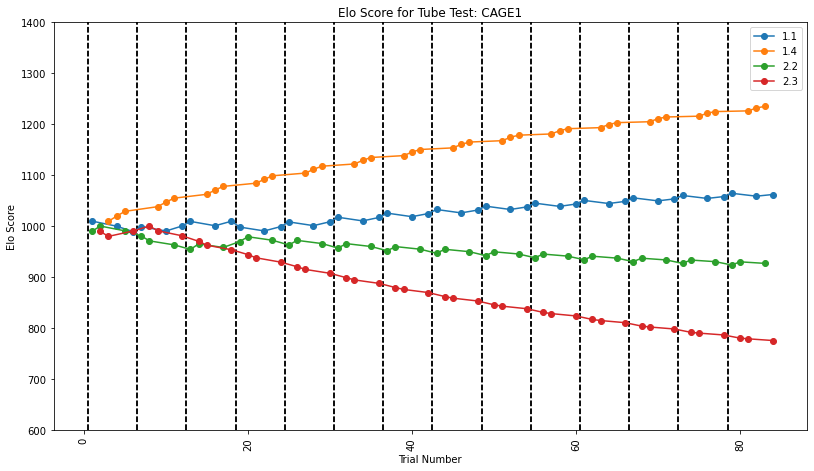

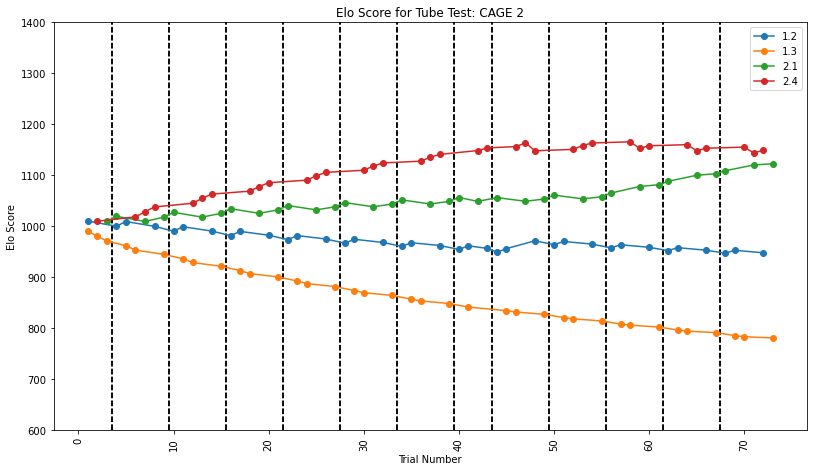

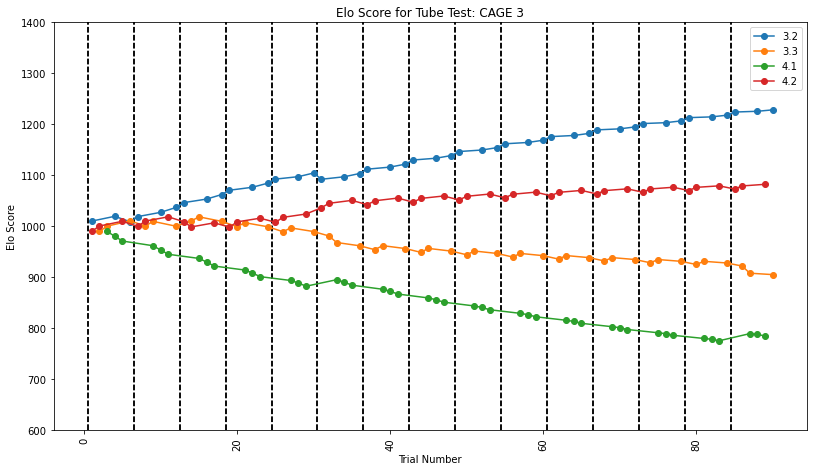

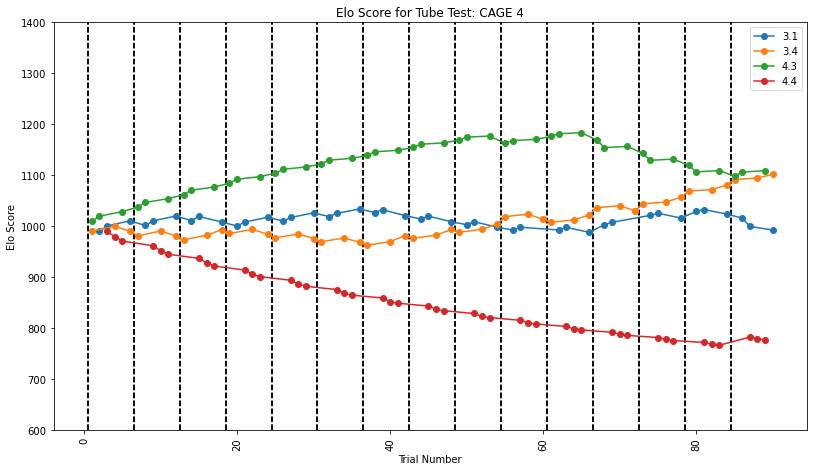

In [90]:
for key, value in sheet_to_data_frame.items():
    plt.rcParams["figure.figsize"] = (13.5,7.5)

    elo_score_data_frame = value["elo_score_data_frame"]
    fig, ax = plt.subplots()

    # Drawing vertical lines that represent when each session begins
    for index, row in elo_score_data_frame.dropna(subset=["session_number_plotting"]).iterrows():
        # Offsetting by 0.5 to avoid drawing the line on the dot
        plt.vlines(x=[row["total_match_number"] - 0.5], ymin=600, ymax=1400, colors='black', linestyle='dashed')

    # Drawing a line for each subject
    for subject in sorted(elo_score_data_frame["subject_id"].astype(str).unique()):
        # Getting all the rows with the current subject
        subject_df = elo_score_data_frame[elo_score_data_frame["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        plt.plot(subject_df["total_match_number"], subject_df["updated_elo_score"], '-o', label=subject)

    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for Tube Test: {}".format(key))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(600, 1400) 
    
    file_name = "tube_test_elo_score_{}_date_{}_{}.png".format(key, earliest_date, latest_date)
    plt.savefig(os.path.join(output_directory, file_name))
    
    plt.show()


# Saving the Dataframes

In [64]:
output_directory = "./proc/elo_score_spread_sheets/tube_test_elo_score/cage_{}_date_{}_{}".format(all_cages, earliest_date, latest_date)

In [65]:
output_directory

'./proc/elo_score_spread_sheets/tube_test_elo_score/cage_1_2_3_4_date_2022-04-26_2022-05-20'

In [66]:
os.makedirs(output_directory, exist_ok=True)

In [67]:
file_name = "tube_test_elo_score_history_cages_{}_date_{}_{}.csv".format(all_cages, earliest_date, latest_date)
all_sheet_elo_scord_df_combined.to_csv(os.path.join(output_directory, file_name))

In [68]:
file_name = "tube_test_final_elo_score_cages_{}_date_{}_{}.csv".format(all_cages, earliest_date, latest_date)
id_to_final_elo_score_df.to_csv(os.path.join(output_directory, file_name))